Import neccessary libraries

In [80]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, classification_report, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

Task 1: Data Preprocessing

In [81]:
data = pd.read_csv('Wholesale customers data - A.csv')
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
dtypes: int64(7)
memory usage: 24.2 KB
None
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.0

All the features other than Channel & Region clearly require normalization to be implemented.Since the max values of Channel & Region does have a slight difference of 1, we might as well normalize them as well to mitigate what little deviation they might add to the model. Furthermore, there doesn't seem to be any null values. This means we don't have to perform any imputation.

In [82]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Convert the scaled data back into a DataFrame with the original column names
data_scaled_df = pd.DataFrame(data_scaled, columns=data.columns)

# Save the scaled DataFrame to a CSV file
data_scaled_df.to_csv('Wholesale_customers_data_scaled.csv')

Task 2: Implementing K-means & Hierarchical clustering

K-means clustering

Determine the optimal number of clusters with the help of mean-silhouette graph

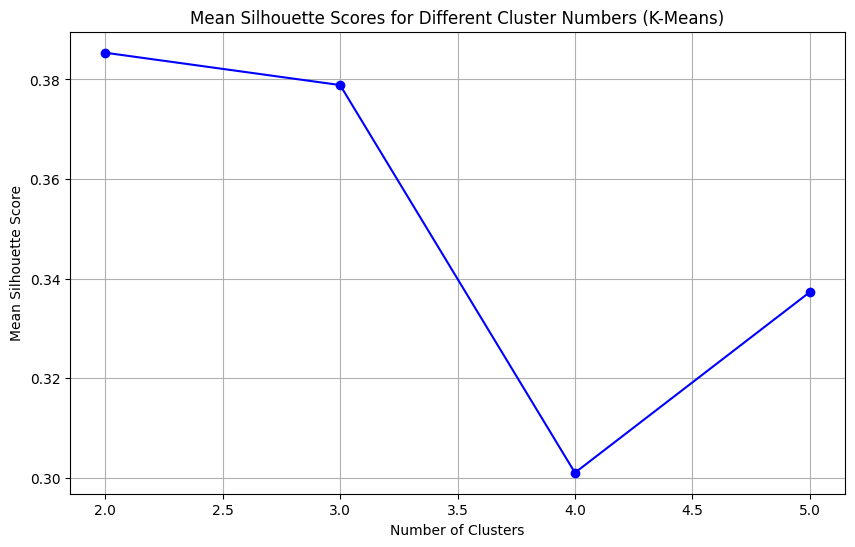

In [83]:
meanSilhouette_scores = []
# test for cluster numbers 2 to 5
probable_clusters = range(2,6)

for cluster in probable_clusters:
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    mean_silhouette = silhouette_score(data_scaled, cluster_labels)
    meanSilhouette_scores.append(mean_silhouette)

# Plotting Mean Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(probable_clusters, meanSilhouette_scores, marker='o', color='b')
plt.title('Mean Silhouette Scores for Different Cluster Numbers (K-Means)')
plt.xlabel('Number of Clusters')
plt.ylabel('Mean Silhouette Score')
plt.grid(True)
plt.show()

Therefore, the number of optimal clusters can be concluded as two for KMean Clustering

Find number of clusters for Hierarchical clustering

In [84]:
# plt.figure(figsize=(10, 6))
# linked = linkage(data_scaled, method='ward')  # Using Ward's method for hierarchical clustering
# dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
# plt.title('Dendrogram')
# plt.xlabel('Data')
# plt.ylabel('Euclidean Distance')
# plt.show()

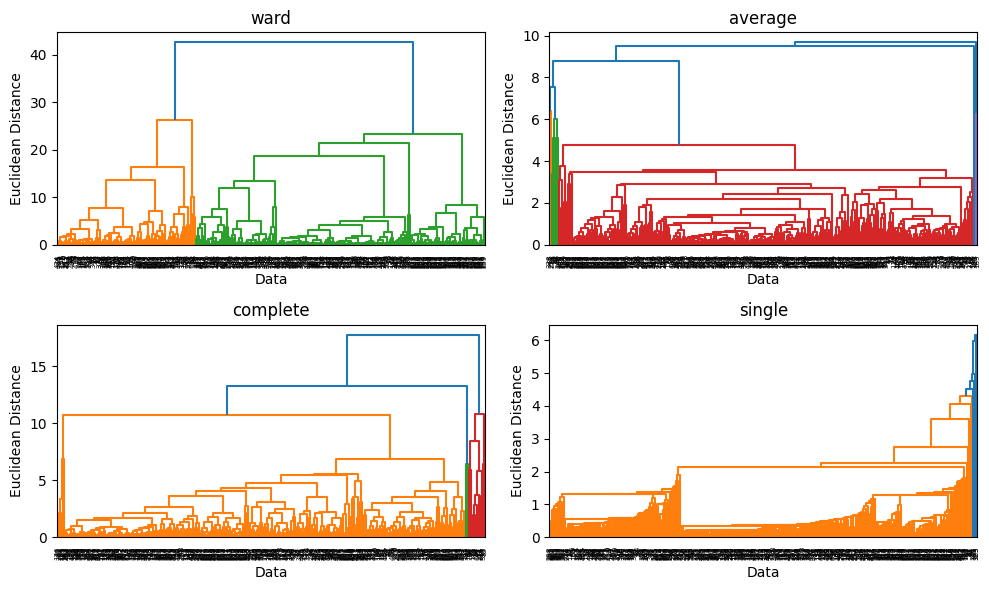

In [85]:
# Define a figure with 2 rows & 2 cols
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# List all the methods for hierarchical clustering
methods = ['ward', 'average', 'complete', 'single']

# Create Dendograms for each clusters
for i, method in enumerate(methods):
    row, col = divmod(i, 2)
    linked = linkage(data_scaled, method=method)
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True, ax=axes[row, col])
    axes[row, col].set_title(method)
    axes[row, col].set_xlabel('Data')
    axes[row, col].set_ylabel('Euclidean Distance')

plt.tight_layout()
plt.show()

Based on the above diagram, the optimal number of clusters seem to be two.

Now, to implement the two clustering algorithms

First, let's use PCA to reduce the dimensionality of clusters into 2 in order to plot effectively in a 2D space.

In [86]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

Kmeans Clustering

Mean Silhouette score for Kmeans method:  0.5411945945675902


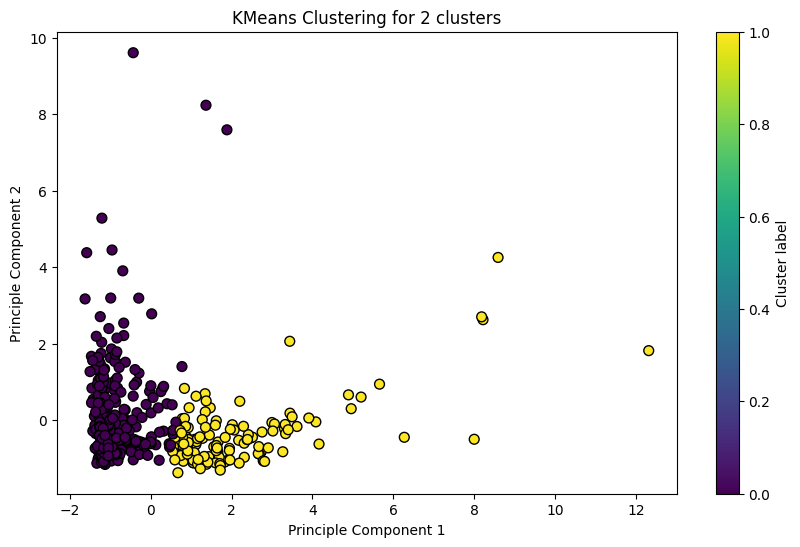

In [87]:
# Get the clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans_labels = kmeans.fit_predict(data_pca)

# print("KMeans Labels: ", kmeans_labels.labels_)
# print("Kmeans Centers: ", kmeans_labels.cluster_centers_)
# print("Kmeans Inertia: ", kmeans_labels.inertia_)

# Get the mean silhouette value
meanSilhouette_kmeans = silhouette_score(data_pca, kmeans_labels)
print("Mean Silhouette score for Kmeans method: ", meanSilhouette_kmeans)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    data_pca[:, 0], data_pca[:, 1], 
    c=kmeans_labels, 
    cmap= 'viridis',
    marker='o',
    edgecolor='k',
    s=50
    )
plt.title('KMeans Clustering for 2 clusters')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar(label='Cluster label')


Calculate the centroids

In [88]:
# Copy the original dataset
dF = data.copy()
# Add predicted labels to the copied dataset
dF['KMeans_Cluster'] = kmeans_labels
# Calculate the mean values for all the features for the 2 two clusters
kmeans_centroids = dF.groupby('KMeans_Cluster').mean()
print("KMeans Centroids: \n", kmeans_centroids)

KMeans Centroids: 
                  Channel    Region         Fresh          Milk       Grocery  \
KMeans_Cluster                                                                 
0               1.054487  2.509615  13767.737179   3383.195513   3973.743590   
1               1.976562  2.625000   7692.164062  11678.125000  17646.515625   

                     Frozen  Detergents_Paper  
KMeans_Cluster                                 
0               3725.368590        814.000000  
1               1479.179688       7921.007812  


Hierarchical Clustering

Mean Silhouette score for Hierarchical method:  0.5436774326008109


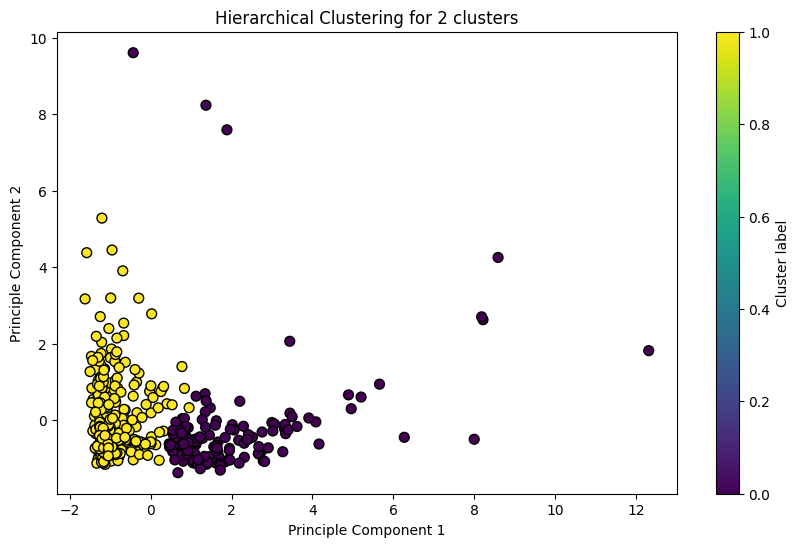

In [89]:
# Get the clusters generated
hierClust = AgglomerativeClustering(n_clusters=2, linkage='ward')
hierLabels = hierClust.fit_predict(data_pca)

# Get mean silhouette value
meanSilhouette_hier = silhouette_score(data_pca, hierLabels)
print("Mean Silhouette score for Hierarchical method: ", meanSilhouette_hier)
# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(
    data_pca[:, 0], data_pca[:, 1], 
    c=hierLabels, 
    cmap= 'viridis',
    marker='o',
    edgecolor='k',
    s=50
    )
plt.title('Hierarchical Clustering for 2 clusters')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.colorbar(label='Cluster label')

Calculate the centroids for hierarchical clustering

In [90]:
# Copy the original dataset
df = data.copy()
# Add predicted labels to the copied dataset
df['Hierarchical_Cluster'] = hierLabels
# Calculate the mean values for all the features for the 2 two clusters
hierarchical_centroids = df.groupby('Hierarchical_Cluster').mean()
print("Hierarchical Centroids: \n", hierarchical_centroids[::-1])

Hierarchical Centroids: 
                        Channel    Region         Fresh          Milk  \
Hierarchical_Cluster                                                   
1                     1.039474  2.506579  13363.723684   3157.164474   
0                     1.955882  2.625000   8952.639706  11695.433824   

                           Grocery       Frozen  Detergents_Paper  
Hierarchical_Cluster                                               
1                      3814.674342  3439.970395        750.759868  
0                     17197.801471  2249.257353       7644.308824  


Task 4: Compare the performance of KMeans with SVM for predicting the feature "Region"

SVM

In [91]:
# Separate features and target variable
X = data.drop('Region', axis=1)
y = data['Region']

# Normalize the features
X_scaled = scaler.fit_transform(X)

# Split the data for training & testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create SVM Model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict region using SVM model
y_pred_svm = svm.predict(X_test)

# Evaluate the performance of SVM model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy: ", svm_accuracy)
print("SVM Classification Report: \n ", classification_report(y_test, y_pred_svm))



SVM Accuracy:  0.8409090909090909
SVM Classification Report: 
                precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         9
           3       0.84      1.00      0.91       111

    accuracy                           0.84       132
   macro avg       0.28      0.33      0.30       132
weighted avg       0.71      0.84      0.77       132



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  